Data Exploration

In [1]:
import pandas as pd
df = pd.read_csv('data.csv', encoding = "ISO 8859-2")
df.head()

,category,screenname,text
0,Information,Barclays,Barclays CEO stresses the importance of regula...
1,Information,Barclays,Barclays announces result of Rights Issue http...
2,Information,Barclays,Barclays publishes its prospectus for its ĺŁ5....
3,Information,Barclays,Barclays Group Finance Director Chris Lucas is...
4,Information,Barclays,Barclays announces that Irene McDermott Brown ...


After cleaning up, this is the first five rows of the data we will be working on:

In [2]:
from io import StringIO
col = ['category', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]

df.columns = ['category', 'text']
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()


,category,text,category_id
0,Information,Barclays CEO stresses the importance of regula...,0
1,Information,Barclays announces result of Rights Issue http...,0
2,Information,Barclays publishes its prospectus for its ĺŁ5....,0
3,Information,Barclays Group Finance Director Chris Lucas is...,0
4,Information,Barclays announces that Irene McDermott Brown ...,0


**Imbalanced Classes : **
We see that the number of cases per category is imbalanced. Text messages are more biased towards Information.

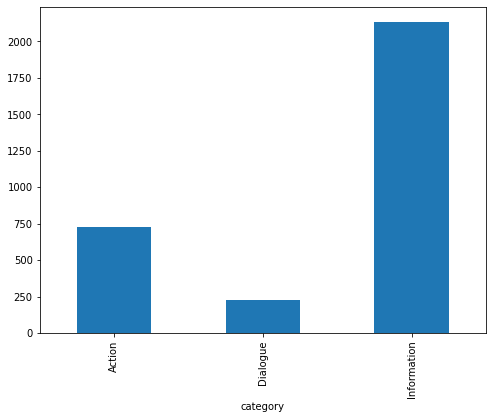

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

**One common approach for extracting features from text is to use the bag of words model**: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
features.shape

(3079, 1860)

We can use **sklearn.feature_selection.chi2** to find the terms that are the most correlated with each of the products:

In [5]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Action':
  . Most correlated unigrams:
. read
. learn
  . Most correlated bigrams:
. formula safe
. learn http
# 'Dialogue':
  . Most correlated unigrams:
. thanks
. citivolunteers
  . Most correlated bigrams:
. photo rt
. great photo
# 'Information':
  . Most correlated unigrams:
. nan
. learn
  . Most correlated bigrams:
. nan gold
. nestle nan


**Multi-Class Classifier: Features and Design**
After all the above data transformation, now that we have all the features and labels. 
**Naive Bayes Classifier:** the one most suitable for word counts is the multinomial variant:

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

After fitting the training set, we now try to do some predictions.

In [7]:
print(clf.predict(count_vect.transform(["Barclays announces result of last quarter."])))

['Information']


We will try the following four models:
Logistic Regression, 
(Multinomial) Naive Bayes,
Linear Support Vector Machine,
Random Forest.

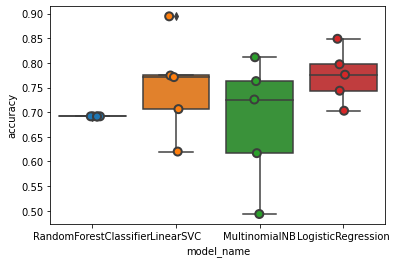

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [9]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.753212
LogisticRegression        0.773652
MultinomialNB             0.682082
RandomForestClassifier    0.691458
Name: accuracy, dtype: float64

Continue with  **(LinearSVC)**, we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

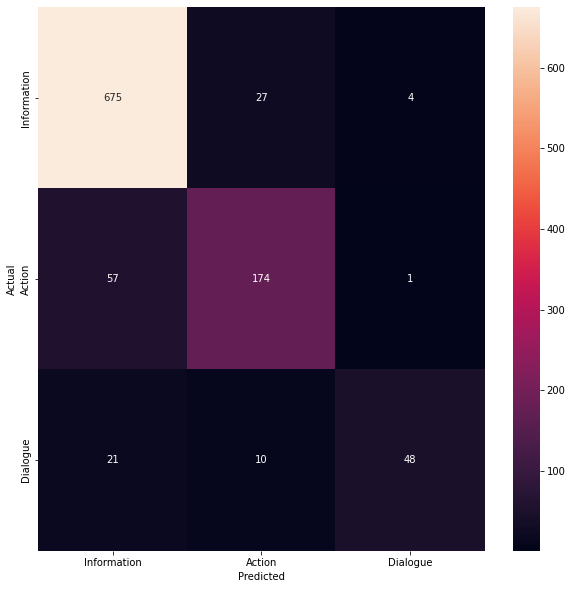

In [10]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

There are a number of misclassifications, and it might be interesting to see what those are caused by:

In [11]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'text']])
      print('')

'Action' predicted as 'Information' : 57 examples.


,category,text
2503,Action,Pfizer provides an update to its development p...
1938,Action,1 year on: See what we've achieved with the Fa...
1427,Action,Innovative research &amp groundbreaking partn...
1672,Action,Our CEO P.Bulcke speaks to #CNN about the help...
550,Action,Over 800 #CitiVolunteers in 11 countries acros...
1479,Action,@Stun NestlĚŠ believes access to water should ...
498,Action,Why do u #volunteer? #Citi's Mei Yang loves th...
1846,Action,Food Question of the Day: Which #fruit is know...
3085,Action,The @UNCF Ě˘âÂĺ˘ Merck Science Initiative ann...
2982,Action,How to stay healthy while building your startu...



'Dialogue' predicted as 'Information' : 21 examples.


,category,text
1857,Dialogue,Thanks. More work ahead RT@ScottPoynton Update...
574,Dialogue,Well done team! RT @gmitcalfe #CitiVolunteers ...
503,Dialogue,@VNATexas Glad we could give back! #Citivolunt...
1768,Dialogue,@medskep Tests reconfirm #Nestle infant formul...
3058,Dialogue,PfizerĚ˘âÂă˘s Adele Gulfo honored with @Spri...
2828,Dialogue,@GCIHealth Kudos to the diabetes team! Congrats!
2539,Dialogue,"@jonmrich No, not in this context. @agDesignNe..."
1293,Dialogue,Thank you Dr. Hilleman! http://t.co/8TZIlm2fUU...
495,Dialogue,#CitiVolunteers in 20+ cities in #Asia Pacific...
1482,Dialogue,@NatArchary sorry for the inconvenience caused...



'Information' predicted as 'Action' : 27 examples.


,category,text
1490,Information,@peggytanous We`ve voluntarily recalled limite...
671,Information,Ingenuity fuels learning-Belo Horizonte City C...
1503,Information,@Fox2now We have voluntarily recalled limited ...
30,Information,Employee benefits failing to meet expectations...
3081,Information,"Study: ""Children cooking with a parent ate mor..."
2348,Information,The latest Human-TECH post on TSN continues di...
2981,Information,How do you use #crowdsourcing? @BjarkeIngels r...
33,Information,65% of Gen Y employees would value financial e...
23,Information,ŰĎEmployers must now address the fundamental ...
2332,Information,One of the new models being used in #drug safe...



'Dialogue' predicted as 'Action' : 10 examples.


,category,text
1723,Dialogue,@joycemakitalo @TV5manila Please be reassured ...
1410,Dialogue,"From the Merck family to yours, we wish you a ..."
1508,Dialogue,@najibcherif We have voluntarily recalled limi...
1745,Dialogue,"@LISAJANEPARKER Hi LisaJane, we want to reassu..."
1058,Dialogue,"@morpheusweb Hello, just checked with customer..."
1280,Dialogue,Thanks to everyone at #USCA2013 who added thei...
1299,Dialogue,Proud to call you partners! @HLFPPT @Pathfinde...
1690,Dialogue,@FoodMuse surely you should blame the develope...
1488,Dialogue,@foodsafeguru We`ve voluntarily recalled limit...
1875,Dialogue,@DebWharfe Australian tests have reconfirmed #...


we use the **chi-squared test** to find the terms that are the most correlated with each of the categories:

In [12]:
model.fit(features, labels)
N = 2
for category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Action':
  . Top unigrams:
       . read
       . learn
  . Top bigrams:
       . learn http
       . read http
# 'Dialogue':
  . Top unigrams:
       . thanks
       . congrats
  . Top bigrams:
       . good work
       . fun rt
# 'Information':
  . Top unigrams:
       . canada
       . danone
  . Top bigrams:
       . sold http
       . responsibility merck


Finally, we print out the classification report for each class:

In [13]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['category'].unique()))

              precision    recall  f1-score   support

 Information       0.90      0.96      0.93       706
      Action       0.82      0.75      0.79       232
    Dialogue       0.91      0.61      0.73        79

    accuracy                           0.88      1017
   macro avg       0.88      0.77      0.81      1017
weighted avg       0.88      0.88      0.88      1017

